In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

from imblearn.over_sampling import SMOTE 

from pandas_profiling import ProfileReport

# EDA Tools

In [3]:
df=pd.read_csv('data/travel_insurance.csv')
df['claim_num'] = [0 if x == 'No' else 1 for x in df['claim']]

### Pandas profiling is being used to automatically generate exploratory analysis of the data set. 

Main goals of the report are to identify:

- Any missing or unusual characteristics (e.g., skew, low incidence, etc.) in the data
- Get a sense of correlations between variables (both features and outcomes)
- miscelaneous data issues

In [4]:
profile = ProfileReport(df, title='tbd Insur Profiling Report', explorative=True)

The below code will save the exploratory data analysis to an html file that can be evaluated for issues. 

In [6]:
profile.to_file("tbd-insur eda output.html")
;

''

### Based on assessment of the report there are several issues that need to be addressed before modeling:
- High missingness in Gender variable
- High cardinality in destination variable. For simplicity, will likely bin to high medium low destination categories.
- Duration is highly skewed and contains missing values

If interested in this assessment, you can view report output in "tbd-insur eda output.html" in this repo

## Cleaning Data for modeling



### Cleaning gender column
There are three categories in the gender column, male, female, and missing. 
There may be useful information in this column, so we'll create two columns, one for male and one for female, to compare against missing in the final model. 

In [5]:
df=pd.concat([df,pd.get_dummies(df['gender'])], axis = 1)

In [6]:
df.head()

,agency,agency_type,distribution_channel,product_name,claim,duration,destination,net_sales,commision,gender,age,claim_num,F,M
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81,0,1,0
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71,0,1,0
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32,0,0,0
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32,0,0,0
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41,0,0,0


### Dealing with High Cardinality in Destination
There are a lot of values in the destination column (makes sense, lots of countries in the world!).

The following code will create a new column with frequency of visits to destination (i.e., Count of destination / number of rows in data set). The goal of this column is to indicate if more or less frequent destinations are associated with more or fewer claims(i.e., popularity of country in this data set). 

There are several notable limits to this if it were used in production:
- The desination frequency number would need to be fixed or re-calculated on a regular basis.
- If frequencies are re-calculated models would need to be re-estimted to account for changes in underlying data generating process. 
- A better soltion would be to bin on high / medium / low destination countries, but would require more complete data set. 

These limitations seem reasonable given the demo context. 

In [7]:
dest_freq = df.groupby('destination').size()/len(df)

In [8]:
# Map the frequency counts back to the destination
df.loc[:,'destination_freq'] = df['destination'].map(dest_freq)

In [9]:
df.head()

,agency,agency_type,distribution_channel,product_name,claim,duration,destination,net_sales,commision,gender,age,claim_num,F,M,destination_freq
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81,0,1,0,0.093642
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71,0,1,0,0.093642
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32,0,0,0,0.058333
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32,0,0,0,0.058333
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41,0,0,0,0.007185


### Adjusting Skewness in Duration

To keep things simple, any duration values less than 1 or greater than 190 (95th percential) will be dropped. This is due to suspected issues with data.

Following this, a natural log transformation will be applied to duraiton to remove skewness.

In [10]:
df = df.loc[(df.duration > 0) & (df.duration < 190)]

In [11]:
df['log_duration'] = np.log(df.duration)

<AxesSubplot:xlabel='duration', ylabel='Density'>

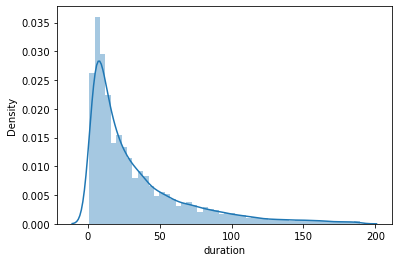

In [12]:
sns.distplot(df.duration)

<AxesSubplot:xlabel='log_duration', ylabel='Density'>

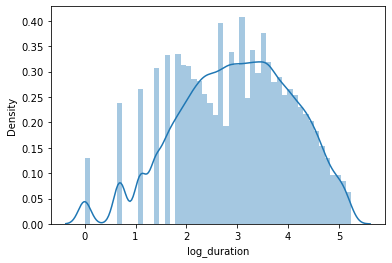

In [13]:
sns.distplot(df.log_duration)

### Final data prep
The pandas profiling report indicated there was a degree of correlation between some categorical variables:
- agency and agency_type
- agency and distribution channel
- agency and product type
- product name and agency_type, distribution channel, and agency

Generally, the above suggests agencies likely specialize in offerings. For the purpose of modeling, only the following categorical variables will be kept:
- agency type (Airlines / Travel Agency)
- Distribution Channel (Online / Offline)

Product Name is being exluded due to lack of understanding. It is reasonable that these products should have a meaningful groupings, but we don't have apriori knowledge on this. As an exploratory step, we'll finish this analysis with an explortory model with all product names included as predictors. 

The final step of data preperation will convert categorical variables into numberic variables, as required for modeling. These will be automatically processed using 

In [14]:
#making categorical column ready for model fitting
agency_type_dummy = pd.get_dummies(df['agency_type'])
dist_chan_type_dummy = pd.get_dummies(df['distribution_channel'])

df = pd.concat([df,agency_type_dummy,dist_chan_type_dummy], axis = 1)

Clean up some of the features after processing

In [15]:
drop_cols = ['agency_type', 'distribution_channel', 'gender', 'destination', 
             'product_name', 'agency', 'claim','claim_num', 'duration']

X = df.drop(drop_cols, axis = 1)


In [16]:
y = df['claim_num']
y.value_counts()

0    59371
1      716
Name: claim_num, dtype: int64

### Add interaction terms for additional features

In [17]:
X['male_x_age'] = X.age * X.M
X['female_x_age']  = X.age * X.F
X['dest_freq_x_log_duration'] = X.destination_freq * X.log_duration
X.reset_index(inplace = True, drop = True)

#### Apply min max scaling to prep model for random forest algorithim

In [18]:
# Scale only columns that have values greater than 1
to_scale = [col for col in X.columns if X[col].max() > 1]
mms = MinMaxScaler()
to_scale
scaled = mms.fit_transform(X[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

#Replace original columns with scaled ones
for col in scaled:
    X[col] = scaled[col]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8187)

### Check to ensure rate of claims is similar between test and train sets


In [20]:
print(f'''Positive class in Train = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}%
Positive class in Test  = {np.round(y_test.value_counts(normalize=True)[1] * 100, 2)}%''')

Positive class in Train = 1.18%
Positive class in Test  = 1.22%


In [21]:
mod_base = RandomForestClassifier(random_state = 8187)
mod_base = mod_base.fit(X_train, y_train)
preds = mod_base.predict(X_test)

Accuracy = 0.99
Recall = 0.01



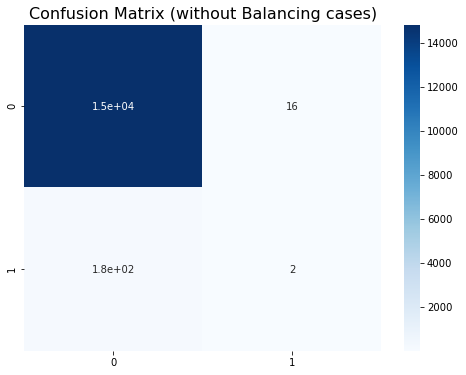

In [22]:
# Evaluate
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (without Balancing cases)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Unsurprisingly, the model has very high accuracy (easy to guess no claim), but does an exceptionally poor job at correctly predicting when a claim will be filed (about 2% as indicated by recall). 

Let's try the model again, but this time using SMOTE to try to create additional simulated cases of filed claims. 
- For more information on SMOTE technique see a more detailed explanation at https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [23]:
smote = SMOTE(random_state=8187)
X_smoted, y_smoted = smote.fit_resample(X, y)
print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_smoted.shape}''')
print('\nBalance of positive and negative classes (%):')
y_smoted.value_counts(normalize=True) * 100

Shape of X before SMOTE: (60087, 14)
Shape of X after SMOTE: (118742, 14)

Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: claim_num, dtype: float64

Accuracy = 0.98
Recall = 0.98



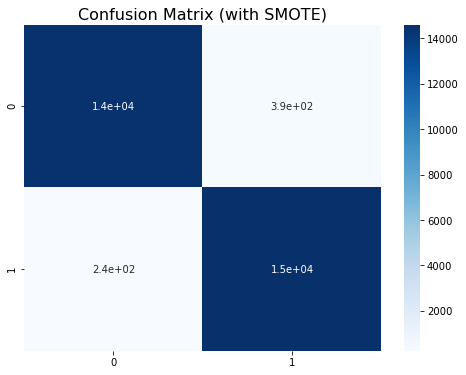

In [24]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(
    X_smoted, y_smoted, test_size=0.25, random_state=8187
)

mod_smote = RandomForestClassifier(random_state=8187)
mod_smote.fit(X_train_sm, y_train_sm)
preds_sm = mod_smote.predict(X_test_sm)

print(f'Accuracy = {accuracy_score(y_test_sm, preds_sm):.2f}\nRecall = {recall_score(y_test_sm, preds_sm):.2f}\n')
cm = confusion_matrix(y_test_sm, preds_sm)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (with SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

### Now try the new model applied to the orginal test data. 
This will help to understand if SMOTE is introducing some artifacts inflating model performance, or if it is generally increasing the ability of our model to successfully identify claimed policies. 
- this isn't perfect as there is likely some data leakage, but an interesting exercise. 

Accuracy = 0.99
Recall = 0.80



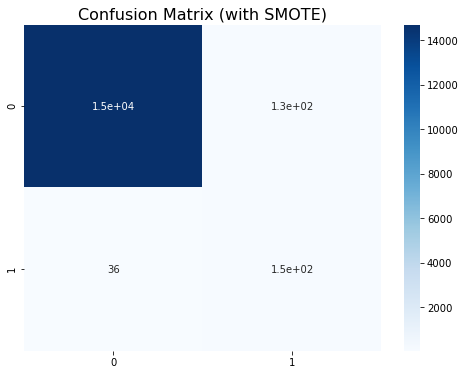

In [25]:
preds_sm_orginal_model = mod_smote.predict(X_test)
print(f'Accuracy = {accuracy_score(y_test, preds_sm_orginal_model):.2f}\nRecall = {recall_score(y_test, preds_sm_orginal_model):.2f}\n')

cm = confusion_matrix(y_test, preds_sm_orginal_model)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (with SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Note the overwhelming number of predictions are that a claim is not filed, which is expected as most.  
However, there is a dramatic improvement in the model's ability to correctly identify claims actually filed. Model performance increased from predicting 2% -> 80% of filed claims correctly. 

## Conclusion
The model devloped here does a relatively good job of recovering and predicting when a policy may result in a claim being filed. The main finding demonstrated in this simple case study is that methods for dealing with class imbalance appear to be incredibly valuable to this space. Claims are relatively rare, so utilizing methods that intelligently create new synthetic cases can help to dramatically increase model performance. 

It is important to note that this is a relatively simple model, and more work would be needed before introducing into a production environment. For exmaple:
- Better understanding of destination biases in data. Singapore appeared to have a much higher incidence of claims being filed compared to other cases. 
- User level characteristics beyond basic demographics and age, may help to shed light on additional factors. 
- Understanding representativeness of agencies used in creating this data set.